### **개요: 음식 재료의 사진을 업로드하면, 만들 수 있는 음식 메뉴를 추천해주고 레시피를 알려줍니다.**

In [1]:
!pip install openai==0.28
!pip install googletrans==4.0.0-rc1
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 880.6 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.4 MB/s eta 0:00:00
  Created wheel for googletr

In [2]:
import openai
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from google.colab import files
import requests
from PIL import Image
from keras.preprocessing import image
from IPython.display import display
from googletrans import Translator
from keras.applications.inception_v3 import decode_predictions
import ipywidgets as widgets
from io import BytesIO

In [3]:
'''
* openai_response(): Open AI 요청 함수
* parameter
* 1. prompt: 프롬프트 텍스트
'''
def openai_response(prompt):
    # OpenAI API 키 설정
    openai.api_key = 'hide_key_for_security'
    # request
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=1500
    )
    # response text 리턴
    return response.choices[0].text.strip()

In [4]:
'''
* translate_name(): 음식 재료 이름을 영어 >> 한국어로 번역하는 함수
* parameter
* 1. english_name: 영어로 된 음식 재료 이름
'''
def translate_name(english_name):
  translator = Translator()
  return translator.translate(english_name, 'ko', 'en').text

In [5]:
# output class 정의
classes = ['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [6]:
'''
* get_menu(): 재료들로 만들 수 있는 음식 메뉴 추천 함수
* parameter
* 1. ingredients_name: 재료들의 이름 텍스트
'''
def get_menu(ingredients_name, food_category, user_level):
    # ChatGPT를 사용하여 메뉴 3개 추천하기
    prompt = f"{food_category}중에서 요리 실력이 {user_level}인 사용자가 {ingredients_name}로 요리할 수 있는 음식 메뉴 3개 단어를 ,로 띄워서 한줄로 알려줘"
    menu_response = openai_response(prompt)
    print(menu_response)

In [7]:
'''
* get_recipe(): 레시피 생성 및 출력 함수
* parameter
* 1. food_name: 레시피를 생성할 음식 이름
'''
def get_recipe(food_name):
    print(f"[ {food_name} 만드는 레시피 ]\n")
    recipe_response = "(1) 재료\n\n"

    # ChatGPT를 사용하여 레시피 알려주기
    prompt = f"{food_name} 만드는데 필요한 재료 알려줘"
    recipe_response += openai_response(prompt)

    recipe_response += "\n\n(2) 레시피\n\n"
    prompt = f"\n{food_name} 만드는 순서 알려줘"
    recipe_response += openai_response(prompt)
    print(recipe_response)

In [20]:
'''
* recognized_food(): 음식 재료 이미지 분류 함수
* parameter
* 1. images: {<food_name>:<food_content>} 형태의 Dictionary
'''
def recognized_food(images):
    # GitHub에 저장한 모델 파일 다운로드
    github_raw_url = 'https://raw.githubusercontent.com/milijung/MenuRecommendation_ChatBot/main/food_ingredient_recognition_model.pth'
    model_path = 'food_ingredient_recognition_model.pth'
    torch.hub.download_url_to_file(github_raw_url, model_path, progress=True)

    # 모델 로드
    model = torch.load(model_path, map_location=torch.device('cpu'))

    # 이미지 전처리 코드
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    food_name = ""

    for key in images.keys():
        file_content = images[key]

        # 파일 내용을 BytesIO로 읽음
        file_content_bytesio = BytesIO(file_content)

        # 이미지를 PIL Image로 변환
        input_image = Image.open(file_content_bytesio).resize((224, 224))
        display(input_image)

        # 이미지 전처리
        input_image = preprocess(input_image)
        input_image = input_image.unsqueeze(0)

        with torch.no_grad():
            model.eval()  # 모델을 평가 모드로 설정
            outputs = model(input_image)
            predictions = torch.nn.functional.softmax(outputs[0], dim=-1)

            # 예측 결과 디코딩 (top1)
            _, predicted_class = torch.max(predictions, 0)

            # predicted_class를 이용하여 예측한 class의 index 디코딩
            label = predicted_class.item()

            food_name += translate_name(classes[label]) + ', '

    return food_name[:-2]

1. 사용자가 완성된 음식 재료 이미지들을 업로드하면, 객체 인식 AI가 어떤 음식재료 인지 인식합니다.

In [31]:
# 1. 음식 재료 이미지 업로드
print("안녕하세요! 가지고 있는 재료들을 찍어서 올려주세요.\n")

uploaded = files.upload()

안녕하세요! 가지고 있는 재료들을 찍어서 올려주세요.



Saving sample.jpg to sample (4).jpg


100%|██████████| 42.8M/42.8M [00:00<00:00, 210MB/s]


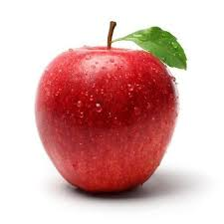

현재 가지고 있는 재료: 사과


In [32]:
ingredients_name = ""

if len(uploaded) != 0:
  # 2. 음식 재료 이미지 인식
  ingredients_name = recognized_food(uploaded)
  # 3. 인식된 재료 이름 목록 출력
  print(f"현재 가지고 있는 재료: {ingredients_name}")

2. 원하는 음식의 메뉴 카테고리 정보를 입력합니다.

In [33]:
def on_change_category(change):
    global food_category
    if change['type'] == 'change' and change['name'] == 'value':
        print("선택된 옵션:", change['new'])
        food_category = change['new']

print('원하는 메뉴 카테고리를 선택해주세요 (Default: 한식)')
radiogroup_category = widgets.RadioButtons(
    options=['한식', '중식', '일식', '양식'],
    disabled=False
)

display(radiogroup_category)
radiogroup_category.observe(on_change_category)

food_category = radiogroup_category.value

원하는 메뉴 카테고리를 선택해주세요 (Default: 한식)


RadioButtons(options=('한식', '중식', '일식', '양식'), value='한식')

선택된 옵션: 중식


3. 사용자의 요리 실력 정보를 입력합니다.

In [34]:
def on_change_option(change):
    global user_level
    if change['type'] == 'change' and change['name'] == 'value':
        print("선택된 옵션:", change['new'])
        user_level = change['new']

print('사용자님의 요리 실력을 선택해주세요 (Default: 초급)')
radiogroup_userlevel = widgets.RadioButtons(
    options=['초급', '중급', '고급'],
    disabled=False
)

display(radiogroup_userlevel)
radiogroup_userlevel.observe(on_change_option)

user_level = radiogroup_userlevel.value

사용자님의 요리 실력을 선택해주세요 (Default: 초급)


RadioButtons(options=('초급', '중급', '고급'), value='초급')

선택된 옵션: 중급


4. Open AI의 API를 사용하여 해당 재료로 만들 수 있는 음식 메뉴를 3개 추천합니다.

In [35]:
if len(uploaded) != 0:
  print(f"해당 재료로 만들 수 있는 {food_category} 음식 메뉴는 다음과 같아요:\n")
  menu_list = get_menu(ingredients_name, food_category, user_level)

해당 재료로 만들 수 있는 중식 음식 메뉴는 다음과 같아요:

사과 빵,사과 샐러드,사과 파이


5. 사용자가 음식을 선택하면, Open AI의 API를 사용하여 요청한 음식의 레시피를 출력합니다.

In [36]:
food_name = input("레시피를 원하는 음식의 이름을 작성해주세요: ")

print()
get_recipe(food_name)

레시피를 원하는 음식의 이름을 작성해주세요: 사과 파이

[ 사과 파이 만드는 레시피 ]

(1) 재료

- 사과: 2개
- 바닐라 시럽: 2 티스푼
- 설탕: 1/4 컵
- 베이킹 소금: 1/4 티스푼
- 감자 전분: 1/4 컵
- 버터: 4 테이블스푼
- 커피향신료: 1/4 티스푼
- 식빵 분말: 1/2 컵
- 사과 식초 또는 사과즙:  1/4 컵

(2) 레시피

1. 필요한 재료들을 준비합니다.
    - 밀가루 : 250g
    - 사과 : 500g
    - 버터 : 80g
    - 살짝점은 소금 : 1/4 teaspoon
    - 당근 : 150g
    - 버터 핫케이크 믹스 : 260g
    - 설탕 : 70g
    - 생크림 : 120g
    - 약간 식물성 오일 : 2 1/2 tablespoons
    - 약간 소금 : 1/4 teaspoon
    - 찹스탠드 또는 프라이 파스타 팬
2. 반죽을 만드는 동안 접시에 사과를 놓아 단것이 될 때까지 썰어줍니다.
3. 버터와 소금, 설탕, 생크림, 식물성 오일을 넣고 잘 섞어줍니다.
4. 밀가루를 접시에 골고루 뿌려줍니다. 여기에 당근과 버터 핫케이크 믹스를 넣고 잘 섞어줍니다.
5. 사과와 반죽을 따로 넣고 깨끗한 그릇에 잘 섞어줍니다.
6. 찹스탠드 또는 프라이 파스타 팬에 잘 채운 후 엄지손가락으로 깔끔하게 널어줍니다.
7. 오븐을 미리 데칼하고 사과 파이를 넣고 190°C에서 약 35 ~ 40분간 구워줍니다.
8. 적당한 준비가 되었다면 식기를들고 마음껏 즐기시면 됩니다.
